# Task03 基于图神经网络的节点表征学习

## 1 知识梳理

### 1.1 卷积图神经网络（GCN）
- 向量定义：$\displaystyle \mathbf{X}^{\prime} = \mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
\mathbf{\hat{D}}^{-1/2} \mathbf{X} \mathbf{\Theta}$
- 公式定义：$\displaystyle \mathbf{x}^{\prime}_i = \mathbf{\Theta} \sum_{j \in \mathcal{N}(v) \cup
\{ i \}} \frac{e_{j,i}}{\sqrt{\hat{d}_j \hat{d}_i}} \mathbf{x}_j$

### 1.2 图注意力神经网络（GAT）
- 公式定义：$\displaystyle \mathbf{x}^{\prime}_i = \alpha_{i,i}\mathbf{\Theta}\mathbf{x}_{i} +
\sum_{j \in \mathcal{N}(i)} \alpha_{i,j}\mathbf{\Theta}\mathbf{x}_{j}$  
  其中$\displaystyle \alpha_{i,j} =
\frac{
\exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{T}
[\mathbf{\Theta}\mathbf{x}_i \, \Vert \, \mathbf{\Theta}\mathbf{x}_j]
\right)\right)}
{\displaystyle \sum_{k \in \mathcal{N}(i) \cup \{ i \}}
\exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{T}
[\mathbf{\Theta}\mathbf{x}_i \, \Vert \, \mathbf{\Theta}\mathbf{x}_k]
\right)\right)}$

### 1.3 MLP、GCN和GAT训练的比较
- 训练效果比较：  
（1）MLP效果最差，由于只考虑了节点自身属性，忽略了节点之间的连接关系  
（2）GCN和GAT效果比较好，同时考虑了节点自身信息与邻接节点的信息
- GCN与GAT的共同点：  
（1）遵循消息传递范式  
（2）邻接节点变换时，对邻接节点做归一化和线性变换  
（3）邻接节点聚合时，对变换后的邻接节点做`sum`聚合  
（4）中心节点变换时，返回邻接节点聚合阶段的聚合结果  
- GCN与GAT的区别（归一化方法）：  
（1）GCN根据中心节点与邻接节点的度计算归一化系数，GAT根据中心节点与邻接节点的相似度计算归一化系数  
（2）GCN归一化依赖图的拓扑结构，GAT归一化依赖中心节点与邻接节点的相似度

## 2 实战练习

### 2.1 MLP、GCN、GAT在节点分类任务的比较

#### 2.1.1 获取并分析数据集Cora

该Cora是一个论文引用网络，节点代表论文，各节点的属性都是一个1433维的词包特征向量，预测目标是各篇论文的类别（共7类）。

In [1]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='dataset/Cora', name='Cora',
                    transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('======================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(
    f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


#### 2.1.2 节点表征的分布可视化展示

In [2]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
%matplotlib inline

def visualize(color):
    # 使用TSNE方法将高维的节点表征映射到二维平面
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

#### 2.1.3 使用MLP（多层感知机）神经网络进行节点分类

In [3]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

# 构造MLP神经网络
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(MLP, self).__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


In [4]:
model = MLP(hidden_channels=16)
# 定义损失函数
criterion = torch.nn.CrossEntropyLoss()
# 定义Adam优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


def train():
    model.train()
    # 清理梯度
    optimizer.zero_grad()
    # 设置前向传播
    out = model(data.x)
    # 仅根据训练节点计算损失
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    # 导出梯度
    loss.backward()
    # 更新参数
    optimizer.step()
    return loss


for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 010, Loss: 1.8849
Epoch: 020, Loss: 1.7383
Epoch: 030, Loss: 1.5396
Epoch: 040, Loss: 1.3391
Epoch: 050, Loss: 1.1060
Epoch: 060, Loss: 0.9173
Epoch: 070, Loss: 0.7889
Epoch: 080, Loss: 0.6899
Epoch: 090, Loss: 0.6685
Epoch: 100, Loss: 0.6106
Epoch: 110, Loss: 0.5888
Epoch: 120, Loss: 0.5277
Epoch: 130, Loss: 0.5053
Epoch: 140, Loss: 0.5623
Epoch: 150, Loss: 0.4934
Epoch: 160, Loss: 0.4170
Epoch: 170, Loss: 0.4678
Epoch: 180, Loss: 0.4808
Epoch: 190, Loss: 0.4602
Epoch: 200, Loss: 0.4827


In [5]:
def test():
    model.eval()
    out = model(data.x)
    # 输出每一类的概率最大的类别
    pred = out.argmax(dim=1)
    # 检查测试结果
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    # 计算查准率
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc


test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5740


#### 2.1.4 使用GCN图神经网络进行分类

In [6]:
from torch_geometric.nn import GCNConv

# 构建GCN
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x


model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


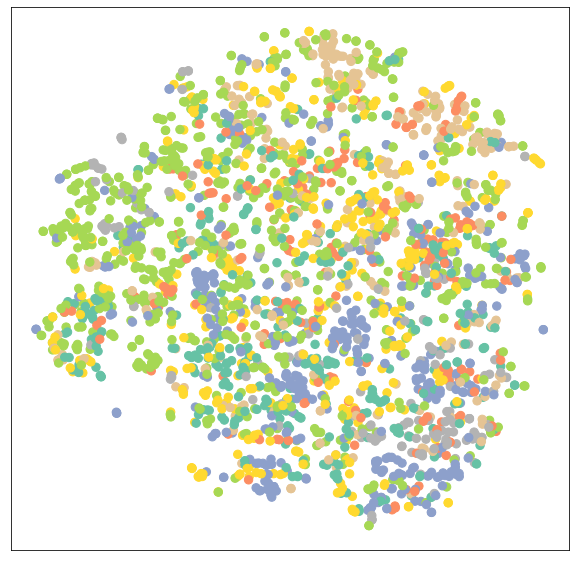

In [7]:
# 用于在测试时添加
model.eval()

out = model(data.x, data.edge_index)
visualize(color=data.y)

In [8]:
# GCN图神经网络的训练
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss


for epoch in range(1, 201):
    if epoch % 10 == 0:
        loss = train()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 010, Loss: 1.9453
Epoch: 020, Loss: 1.9402
Epoch: 030, Loss: 1.9321
Epoch: 040, Loss: 1.9193
Epoch: 050, Loss: 1.9082
Epoch: 060, Loss: 1.8984
Epoch: 070, Loss: 1.8883
Epoch: 080, Loss: 1.8742
Epoch: 090, Loss: 1.8610
Epoch: 100, Loss: 1.8508
Epoch: 110, Loss: 1.8311
Epoch: 120, Loss: 1.8133
Epoch: 130, Loss: 1.8065
Epoch: 140, Loss: 1.7859
Epoch: 150, Loss: 1.7749
Epoch: 160, Loss: 1.7635
Epoch: 170, Loss: 1.7387
Epoch: 180, Loss: 1.7295
Epoch: 190, Loss: 1.7086
Epoch: 200, Loss: 1.6866


In [9]:
# GCN图神经网络的测试
def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7510


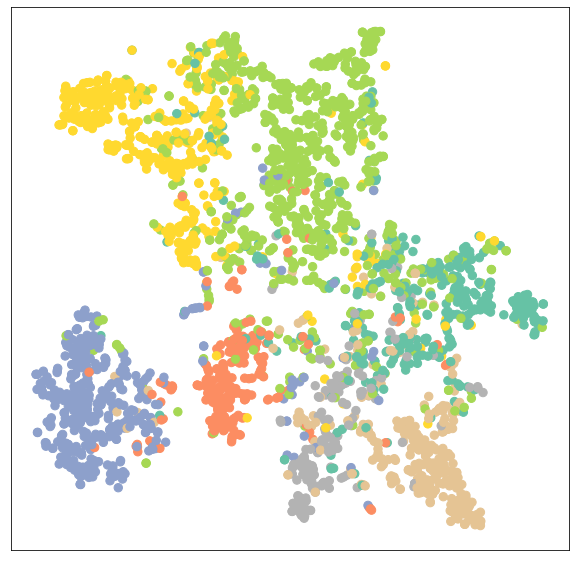

In [10]:
# 展示训练之后的GCN图神经网络生成的节点表征
model.eval()

out = model(data.x, data.edge_index)
visualize(color=data.y)

#### 2.1.5 使用GAT图神经网络进行分类

In [11]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.nn import GATConv

# 构建GAT
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GAT, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GATConv(dataset.num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [12]:
# GAT图神经网络的训练
model = GAT(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss


for epoch in range(1, 201):
    if epoch % 10 == 0:
        loss = train()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 010, Loss: 1.9455
Epoch: 020, Loss: 1.9407
Epoch: 030, Loss: 1.9357
Epoch: 040, Loss: 1.9260
Epoch: 050, Loss: 1.9167
Epoch: 060, Loss: 1.9112
Epoch: 070, Loss: 1.9004
Epoch: 080, Loss: 1.8935
Epoch: 090, Loss: 1.8808
Epoch: 100, Loss: 1.8671
Epoch: 110, Loss: 1.8570
Epoch: 120, Loss: 1.8444
Epoch: 130, Loss: 1.8195
Epoch: 140, Loss: 1.8223
Epoch: 150, Loss: 1.8023
Epoch: 160, Loss: 1.7829
Epoch: 170, Loss: 1.7824
Epoch: 180, Loss: 1.7629
Epoch: 190, Loss: 1.7486
Epoch: 200, Loss: 1.7181


In [13]:
# GAT图神经网络的测试
def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7660


### 2.2 习题
使用PyG中不同的图卷积模块在不同的内置数据集上实现节点分类或回归任务。